In [1]:
import cupy as cp

try:
    cp.cuda.Device(0).use()
    print("CUDA is available. Using GPU for computations.")
except cp.cuda.runtime.CUDARuntimeError:
    print("CUDA is not available. Falling back to CPU with NumPy.")
    import numpy as np
    cp = np  


CUDA is available. Using GPU for computations.


In [3]:
import cupy as cp
import numpy as np
from collections import Counter
import random
import re
from datasets import load_dataset
from tqdm import tqdm
import pickle


def get_array_module(x):
    return cp.get_array_module(x)


def tokenize(text):
    return re.findall(r'\b[a-z]{1,}\b', text.lower())


print("Loading WikiText-2 dataset...")
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
train_text = ' '.join(dataset['train']['text'])

print("Tokenizing text...")
tokens = tokenize(train_text)
print(f"Total tokens before subsampling: {len(tokens)}")


Loading WikiText-2 dataset...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Tokenizing text...
Total tokens before subsampling: 1679656


In [4]:
vocab_size = 1000000
print(f"Building vocabulary of top {vocab_size} words...")
counter = Counter(tokens)
most_common = counter.most_common(vocab_size - 1) 
word2idx = {word: idx + 1 for idx, (word, _) in enumerate(most_common)}
word2idx['<UNK>'] = 0
idx2word = {idx: word for word, idx in word2idx.items()}

print("Converting tokens to indices...")
token_indices = [word2idx.get(token, 0) for token in tokens]
del tokens 
print(f"Total token indices before subsampling: {len(token_indices)}")

Building vocabulary of top 1000000 words...
Converting tokens to indices...
Total token indices before subsampling: 1679656


In [5]:
def subsample(token_indices, counter, idx2word, threshold=1e-5):
    total_count = sum(counter.values())
    word_freq = {word: count / total_count for word, count in counter.items()}
    # Calculate discard probability for each word
    discard_prob = {word: 1 - cp.sqrt(threshold / freq) for word, freq in word_freq.items()}
    # Replace words with probability of being discarded
    subsampled = []
    for idx in tqdm(token_indices, desc="Subsampling"):
        word = idx2word.get(idx, '<UNK>')
        prob = discard_prob.get(word, 0)
        if random.random() > prob:
            subsampled.append(idx)
    return subsampled

print("Applying subsampling to reduce the number of training pairs...")
subsampled_token_indices = subsample(token_indices, counter, idx2word, threshold=1e-5)
print(f"Total tokens after subsampling: {len(subsampled_token_indices)}")
del token_indices  

Applying subsampling to reduce the number of training pairs...


Subsampling: 100%|██████████| 1679656/1679656 [01:51<00:00, 15033.32it/s]

Total tokens after subsampling: 479777


In [6]:
def generate_training_pairs(token_indices, window_size=5, max_context=3):
    pairs = []
    for idx, target in enumerate(token_indices):
        window = random.randint(1, window_size)
        start = max(idx - window, 0)
        end = min(idx + window + 1, len(token_indices))
        contexts = [token_indices[i] for i in range(start, end) if i != idx]
        if len(contexts) > max_context:
            contexts = random.sample(contexts, max_context)
        for context in contexts:
            pairs.append((target, context))
    return pairs #(target,context)

print("Generating training pairs with limited context...")
training_pairs = generate_training_pairs(subsampled_token_indices, window_size=5, max_context=3)
print(f"Total training pairs after limiting context: {len(training_pairs)}")
del subsampled_token_indices  

print("Shuffling training pairs...")
random.shuffle(training_pairs)


Generating training pairs with limited context...
Total training pairs after limiting context: 1343608
Shuffling training pairs...


In [7]:
def sample_training_pairs(training_pairs, sample_fraction=0.1):
    sample_size = int(len(training_pairs) * sample_fraction)
    sampled_pairs = random.sample(training_pairs, sample_size)
    return sampled_pairs

print("Sampling a subset of training pairs...")
training_pairs_sampled = sample_training_pairs(training_pairs, sample_fraction=0.1)
print(f"Total training pairs after sampling: {len(training_pairs_sampled)}")
del training_pairs  

print("Shuffling sampled training pairs...")
random.shuffle(training_pairs_sampled)

Sampling a subset of training pairs...
Total training pairs after sampling: 134360
Shuffling sampled training pairs...


In [8]:
def create_unigram_distribution(pairs, vocab_size):
    word_counts = Counter([pair[1] for pair in pairs])  # Count context words
    # Including all words in the vocabulary
    counts = cp.array([word_counts.get(i, 0) for i in range(vocab_size)])
    unigram_dist = cp.power(counts, 0.75)
    unigram_dist /= cp.sum(unigram_dist)
    return unigram_dist

print("Creating unigram distribution for negative sampling...")
unigram_dist = create_unigram_distribution(training_pairs_sampled, vocab_size)

def get_negative_samples(unigram_dist, num_negatives):
    negatives = cp.random.choice(
        a=cp.arange(len(unigram_dist)),
        size=num_negatives,
        replace=True,
        p=unigram_dist
    )
    return negatives

Creating unigram distribution for negative sampling...


In [9]:
import cupy as cp
from tqdm import tqdm

embedding_dim = 100  
print(f"Initializing embeddings with dimension {embedding_dim}...")

# Initialize embeddings with small random values on the GPU
target_embeddings = (cp.random.rand(vocab_size, embedding_dim) - 0.5) / embedding_dim
context_embeddings = (cp.random.rand(vocab_size, embedding_dim) - 0.5) / embedding_dim

learning_rate = 0.025
num_epochs = 5
num_negatives = 5
epsilon = 1e-8  

print("Starting training with Euclidean distance objective and normalization...")
for epoch in range(num_epochs):
    total_loss = 0
    print(f"Epoch {epoch+1}/{num_epochs}")
    # Iterate through all training pairs
    for pair in tqdm(training_pairs_sampled, desc=f"Epoch {epoch+1}", unit="pair"):
        target, context = pair

        # Retrieve embeddings
        v_target = target_embeddings[target]      # Shape: (embedding_dim,)
        v_context = context_embeddings[context]  # Shape: (embedding_dim,)

        # --- Normalize Embeddings ---
        # Normalize target and context embeddings
        v_target_norm = v_target / (cp.linalg.norm(v_target) + epsilon)
        v_context_norm = v_context / (cp.linalg.norm(v_context) + epsilon)

        # --- Positive Pair: Minimize Euclidean Distance ---
        # Compute Euclidean distance between normalized target and context
        diff_pos = v_target_norm - v_context_norm
        distance_pos = cp.linalg.norm(diff_pos) + epsilon  # Add epsilon to prevent division by zero

        # Loss for positive pair: minimize distance
        loss_pos = distance_pos

        # Gradients for positive pair
        grad_target_pos = (2 * diff_pos) / distance_pos
        grad_context_pos = (-2 * diff_pos) / distance_pos

        # --- Negative Samples: Maximize Euclidean Distance ---
        # Initialize loss and gradients for negative samples
        loss_neg = 0
        grad_target_neg = cp.zeros(embedding_dim)
        grad_context_neg = cp.zeros(embedding_dim)

        # Sample negative contexts
        negative_samples = get_negative_samples(unigram_dist, num_negatives)

        for neg in negative_samples:
            v_neg = context_embeddings[neg]
            v_neg_norm = v_neg / (cp.linalg.norm(v_neg) + epsilon)

            diff_neg = v_target_norm - v_neg_norm
            distance_neg = cp.linalg.norm(diff_neg) + epsilon  # Add epsilon to prevent division by zero

            # Loss for negative pair: maximize distance (equivalent to minimizing negative distance)
            loss_neg += -distance_neg

            # Gradients for negative pair
            grad_target_neg += (-2 * diff_neg) / distance_neg
            grad_context_neg += (2 * diff_neg) / distance_neg

        # Total loss for this pair
        total_loss += loss_pos + loss_neg

        # --- Update Embeddings ---
        # Combine gradients from positive and negative samples
        total_grad_target = grad_target_pos + (grad_target_neg / num_negatives)
        total_grad_context = grad_context_pos + (grad_context_neg / num_negatives)

        # Update target embedding
        target_embeddings[target] -= learning_rate * total_grad_target

        # Update positive context embedding
        context_embeddings[context] -= learning_rate * grad_context_pos

        # Update negative context embeddings
        for neg in negative_samples:
            context_embeddings[neg] -= learning_rate * (grad_context_neg / num_negatives)

        # --- Normalize Updated Embeddings ---
        # Normalize embeddings after update to maintain unit norm
        target_embeddings[target] /= (cp.linalg.norm(target_embeddings[target]) + epsilon)
        context_embeddings[context] /= (cp.linalg.norm(context_embeddings[context]) + epsilon)
        for neg in negative_samples:
            context_embeddings[neg] /= (cp.linalg.norm(context_embeddings[neg]) + epsilon)

    # Compute average loss for the epoch
    avg_loss = total_loss / len(training_pairs_sampled)
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")


Initializing embeddings with dimension 100...
Starting training with Euclidean distance objective and normalization...
Epoch 1/5


Epoch 1: 100%|██████████| 134360/134360 [17:16<00:00, 129.67pair/s]


Epoch 1 completed. Average Loss: -5.6522
Epoch 2/5


Epoch 2: 100%|██████████| 134360/134360 [17:03<00:00, 131.23pair/s]


Epoch 2 completed. Average Loss: -5.8544
Epoch 3/5


Epoch 3: 100%|██████████| 134360/134360 [17:04<00:00, 131.11pair/s]


Epoch 3 completed. Average Loss: -5.8861
Epoch 4/5


Epoch 4: 100%|██████████| 134360/134360 [17:03<00:00, 131.22pair/s]


Epoch 4 completed. Average Loss: -5.8910
Epoch 5/5


Epoch 5: 100%|██████████| 134360/134360 [17:10<00:00, 130.41pair/s]

Epoch 5 completed. Average Loss: -5.8426


In [10]:

print("Saving embeddings...")

# Move embeddings back to CPU before saving
target_embeddings_cpu = cp.asnumpy(target_embeddings)
context_embeddings_cpu = cp.asnumpy(context_embeddings)

# Save target embeddings
with open('target_embeddings_euc.pkl', 'wb') as f:
    pickle.dump(target_embeddings_cpu, f)

# Save context embeddings (optional, often they are averaged or used similarly)
with open('context_embeddings.pkl', 'wb') as f:
    pickle.dump(context_embeddings_cpu, f)

# Save word2idx and idx2word mappings
with open('word2idx_euc.pkl', 'wb') as f:
    pickle.dump(word2idx, f)
with open('idx2word_euc.pkl', 'wb') as f:
    pickle.dump(idx2word, f)

print("Embeddings and mappings saved successfully!")

# Example: Get embedding for a word
def get_embedding(word, target_embeddings, word2idx):
    idx = word2idx.get(word, 0)
    return target_embeddings[idx]

# Example usage
word = 'king'
embedding_vector = get_embedding(word, target_embeddings_cpu, word2idx)
print(f"Embedding for '{word}':\n{embedding_vector}")


Saving embeddings...
Embeddings and mappings saved successfully!
Embedding for 'king':
[ 0.00853674  0.14966085  0.00896703 -0.19902369 -0.02205614 -0.01943387
 -0.04992679  0.06860145  0.14903259  0.08798689  0.09168188  0.1378241
 -0.16302009  0.02240005  0.03110811  0.0312296  -0.22329371 -0.0379568
  0.06678774 -0.08022792  0.09176282 -0.14921049  0.06367937  0.0419935
  0.12451047  0.0549982   0.0606918   0.13730958 -0.08228583 -0.01395013
 -0.08422132 -0.03575964  0.03306455 -0.09831559 -0.050722    0.21182374
 -0.14542517  0.08059702  0.20061178 -0.14518883 -0.00266016  0.07776968
  0.10473766 -0.08118775 -0.01369363  0.03511497 -0.14546139  0.03548062
 -0.08792255  0.0233385   0.05437136 -0.00505436 -0.15552597  0.04762662
 -0.19019353  0.01075023  0.00653419 -0.10940738 -0.13462307 -0.14738917
 -0.11824629  0.16532309  0.01076363 -0.00386207 -0.05462418 -0.01685747
 -0.15052647 -0.01535166  0.16216321 -0.0470868   0.05350673  0.08497637
  0.08255387  0.03947284  0.01884754  0.

In [11]:
import pandas as pd

simlex_path = 'SimLex-999.txt'  

try:
    simlex_df = pd.read_csv(simlex_path, sep='\t')
    print("Loaded SimLex-999 dataset successfully.")
except FileNotFoundError:
    raise FileNotFoundError(f"SimLex-999 file not found at {simlex_path}. Please upload the SimLex-999.txt file.")

print("\nFirst few entries in SimLex-999:")
print(simlex_df.head())

required_columns = {'word1', 'word2', 'SimLex999'}
if not required_columns.issubset(simlex_df.columns):
    raise ValueError(f"SimLex-999 file must contain the columns: {required_columns}")


Loaded SimLex-999 dataset successfully.

First few entries in SimLex-999:
   word1        word2 POS  SimLex999  conc(w1)  conc(w2)  concQ  Assoc(USF)  \
0    old          new   A       1.58      2.72      2.81      2        7.25   
1  smart  intelligent   A       9.20      1.75      2.46      1        7.11   
2   hard    difficult   A       8.77      3.76      2.21      2        5.94   
3  happy     cheerful   A       9.55      2.56      2.34      1        5.85   
4   hard         easy   A       0.95      3.76      2.07      2        5.82   

   SimAssoc333  SD(SimLex)  
0            1        0.41  
1            1        0.67  
2            1        1.19  
3            1        2.18  
4            1        0.93  


Loaded 'idx2word_euc.pkl' successfully.
Embeddings and mappings loaded successfully!
Shape of target_embeddings: (1000000, 100)
target_embeddings is already a NumPy array.
Loaded SimLex-999 dataset successfully.

First few entries in SimLex-999:
   word1        word2 POS  SimLex999  conc(w1)  conc(w2)  concQ  Assoc(USF)  \
0    old          new   A       1.58      2.72      2.81      2        7.25   
1  smart  intelligent   A       9.20      1.75      2.46      1        7.11   
2   hard    difficult   A       8.77      3.76      2.21      2        5.94   
3  happy     cheerful   A       9.55      2.56      2.34      1        5.85   
4   hard         easy   A       0.95      3.76      2.07      2        5.82   

   SimAssoc333  SD(SimLex)  
0            1        0.41  
1            1        0.67  
2            1        1.19  
3            1        2.18  
4            1        0.93  
Processed 985 out of 999 word pairs.
Spearman's rank correlation: -0.0165
P-value: 0.6050


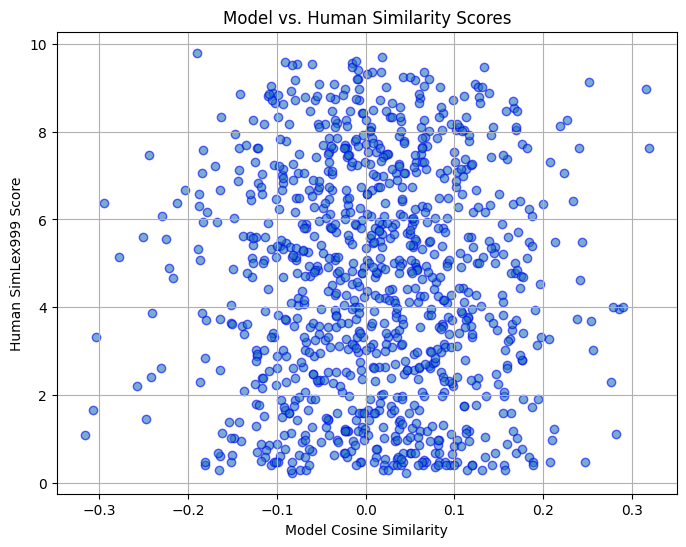

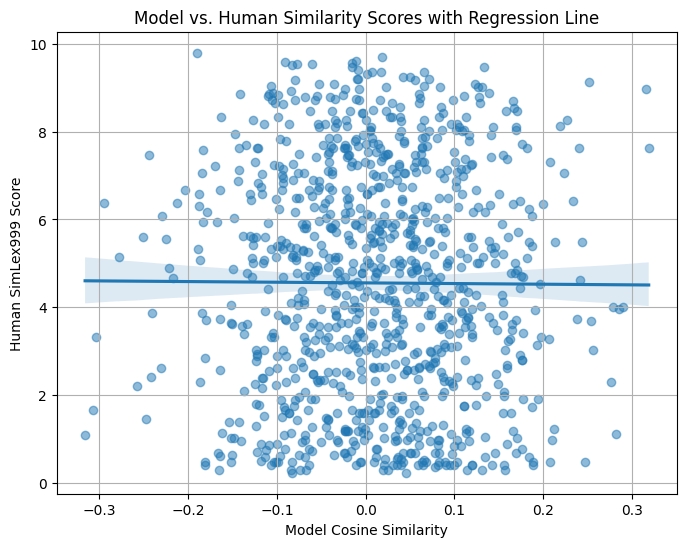

In [12]:


import pickle
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io
import cupy as cp 

with open('target_embeddings_euc.pkl', 'rb') as f:
    target_embeddings = pickle.load(f)

with open('word2idx_euc.pkl', 'rb') as f:
    word2idx = pickle.load(f)

try:
    with open('idx2word_euc.pkl', 'rb') as f:
        idx2word = pickle.load(f)
    print("Loaded 'idx2word_euc.pkl' successfully.")
except FileNotFoundError:
    print("'idx2word_euc.pkl' not found. Proceeding without it.")

print("Embeddings and mappings loaded successfully!")
print(f"Shape of target_embeddings: {target_embeddings.shape}")

if isinstance(target_embeddings, cp.ndarray):
    target_embeddings = target_embeddings.get()  
    print("Converted target_embeddings to NumPy array.")
else:
    print("target_embeddings is already a NumPy array.")

simlex_path = 'SimLex-999.txt'  

try:
    simlex_df = pd.read_csv(simlex_path, sep='\t')
    print("Loaded SimLex-999 dataset successfully.")
except FileNotFoundError:
    raise FileNotFoundError(f"SimLex-999 file not found at {simlex_path}. Please upload the SimLex-999.txt file.")

print("\nFirst few entries in SimLex-999:")
print(simlex_df.head())

# Check for necessary columns
required_columns = {'word1', 'word2', 'SimLex999'}
if not required_columns.issubset(simlex_df.columns):
    raise ValueError(f"SimLex-999 file must contain the columns: {required_columns}")

# Step 6: Compute Cosine Similarities for Word Pairs
from sklearn.metrics.pairwise import cosine_similarity

# Function to retrieve embedding for a word
def get_embedding(word, embeddings, word2idx):
    idx = word2idx.get(word.lower(), None)  # Assuming your vocabulary is in lowercase
    if idx is not None:
        return embeddings[idx]
    else:
        return None

# Lists to store human scores and model scores
human_scores = []
model_scores = []

# Iterate over each row in the SimLex dataset
for index, row in simlex_df.iterrows():
    word1 = row['word1'].lower()
    word2 = row['word2'].lower()
    human_score = row['SimLex999']

    emb1 = get_embedding(word1, target_embeddings, word2idx)
    emb2 = get_embedding(word2, target_embeddings, word2idx)

    if emb1 is not None and emb2 is not None:
        # Ensure embeddings are NumPy arrays
        if isinstance(emb1, cp.ndarray):
            emb1 = emb1.get()
        if isinstance(emb2, cp.ndarray):
            emb2 = emb2.get()

        # Reshape embeddings for cosine_similarity function
        emb1 = emb1.reshape(1, -1)
        emb2 = emb2.reshape(1, -1)

        # Compute cosine similarity
        cos_sim = cosine_similarity(emb1, emb2)[0][0]

        # Append scores
        human_scores.append(human_score)
        model_scores.append(cos_sim)
    else:
        # Skip pairs where at least one word is not in the vocabulary
        pass

print(f"Processed {len(model_scores)} out of {len(simlex_df)} word pairs.")

spearman_corr, p_value = spearmanr(human_scores, model_scores)

print(f"Spearman's rank correlation: {spearman_corr:.4f}")
print(f"P-value: {p_value:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(model_scores, human_scores, alpha=0.6, edgecolors='b')
plt.xlabel('Model Cosine Similarity')
plt.ylabel('Human SimLex999 Score')
plt.title('Model vs. Human Similarity Scores')
plt.grid(True)
plt.show()

plot_df = pd.DataFrame({
    'Model_Similarity': model_scores,
    'Human_Score': human_scores
})

plt.figure(figsize=(8, 6))
sns.regplot(x='Model_Similarity', y='Human_Score', data=plot_df, scatter_kws={'alpha':0.5})
plt.xlabel('Model Cosine Similarity')
plt.ylabel('Human SimLex999 Score')
plt.title('Model vs. Human Similarity Scores with Regression Line')
plt.grid(True)
plt.show()
